In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from model import TPALSTM
from other_models import LSTM
import pandas as pd
from dataset import ElectricityDataModule

In [2]:
data_df = np.load('data/kbest_dataset.npy')
data_df.shape

(35064, 30)

In [3]:
data_splits = {
    "train": 0.7,
    "val": 0.15,
    "predict": 0.15
}

pred_horizon = 4

elec_dm = ElectricityDataModule(
    dataset_splits=data_splits,
    batch_size=256,
    window_size=24,
    pred_horizon=pred_horizon,
    data_style="kbest"
)

In [4]:
run_name = f"{pred_horizon}ts-kbest"

**LSTM**

In [5]:
wandb_logger_lstm = WandbLogger(
    name=f'{run_name}-LSTM',
    save_dir='logs',
    project='Time-Series project',
    log_model=True
)

checkpoint_loss = ModelCheckpoint(
    dirpath=f"checkpoints/{run_name}/LSTM",
    filename='BEST-{epoch}-{val_loss:.3f}-{val_score:.3f}',
    save_top_k=1,
    monitor="val/loss",
    mode="min"
)

lstm_trainer = pl.Trainer(
    max_epochs=40,
    # accelerator='gpu',
    callbacks=[checkpoint_loss],
    devices=1,
    logger=wandb_logger_lstm,
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fraikinarchie (mva-data-challenge). Use `wandb login --relogin` to force relogin


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
lstm = LSTM(
    input_size=data_df.shape[1],
    lstm_hid_size=200,
    linear_hid_size=100,
    output_horizon=pred_horizon,
    n_layers=1,
    lr=1e-3
)

In [7]:
lstm_trainer.fit(lstm, elec_dm)
wandb_logger_lstm.experiment.finish()

/Users/damso/opt/anaconda3/envs/venv/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/damso/MVA/TimeSeries/tpa-lstm-pytorch/checkpoints/4ts-kbest exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type       | Params
-----------------------------------------
0 | lstm      | LSTM       | 185 K 
1 | linear    | Sequential | 20.5 K
2 | criterion | MSELoss    | 0     
-----------------------------------------
206 K     Trainable params
0         Non-trainable params
206 K     Total params
0.824     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/damso/opt/anaconda3/envs/venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/damso/opt/anaconda3/envs/venv/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train/score,█▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val/loss,▃▄▆▆▇█▇▇▆▅▄▄▃▄▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val/score,▄▅▆▇███▇▆▅▅▄▄▅▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▃▂▂▂▂▂▂▂▁▁▁
epoch,39
train/loss,0.00326
train/score,0.10994
trainer/global_step,3839
val/loss,0.00482


In [11]:
elec_dm.setup("predict")

model_path = "/Users/damso/MVA/TimeSeries/tpa-lstm-pytorch/checkpoints/4ts-kbest/BEST-epoch=39-val_loss=0.000-val_score=0.000.ckpt"
lstm = LSTM.load_from_checkpoint(model_path)

pred_dl = elec_dm.predict_dataloader()

y_pred = lstm_trainer.predict(lstm, pred_dl)

Predicting: 0it [00:00, ?it/s]

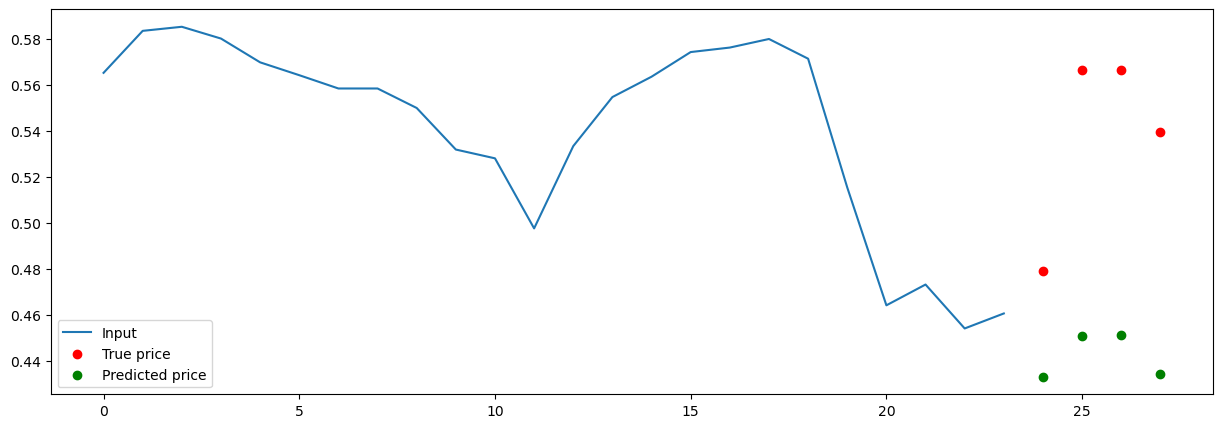

In [12]:
batch_idx = 0
for i, batch in enumerate(pred_dl):
    inputs, labels = batch
    X, ytrue = inputs[batch_idx][:, -1], labels[batch_idx].squeeze()
    ypred = y_pred[i][batch_idx].squeeze()
    # print(inputs.shape)
    # print(labels.shape, y_pred[i].shape)

    plt.figure(figsize=(15, 5))
    plt.plot(range(0, 24), X, label="Input")
    plt.scatter(range(24, 24 + pred_horizon), ytrue, color='red', label="True price")
    plt.scatter(range(24, 24 + pred_horizon), ypred, color='green', label="Predicted price")
    plt.legend()
    plt.show()

    break

**Stacked LSTM**

In [ ]:
wandb_logger_stacked_lstm = WandbLogger(
    name=f'{run_name}-Stacked LSTM',
    save_dir='logs',
    project='Time-Series project',
    log_model=True
)

stacked_lstm_trainer = pl.Trainer(
    max_epochs=80,
    accelerator='gpu',
    strategy='auto',
    devices=1,
    logger=wandb_logger_stacked_lstm
)

In [ ]:
stacked_lstm = LSTM(
    input_size=data_df.shape[1],
    lstm_hid_size=200,
    linear_hid_size=100,
    output_horizon=pred_horizon,
    n_layers=2
)

In [ ]:
stacked_lstm_trainer.fit(stacked_lstm, elec_dm)
wandb_logger_stacked_lstm.experiment.finish()

**TPA-LSTM**

In [ ]:
wandb_logger_tpalstm = WandbLogger(
    name=f'{run_name}-TPA-LSTM',
    save_dir='logs',
    project='Time-Series project',
    log_model=True
)

tpalstm_trainer = pl.Trainer(
    max_epochs=80,
    # accelerator='gpu',
    strategy='auto',
    devices=1,
    logger=wandb_logger_tpalstm
)

In [ ]:
tpa_lstm = TPALSTM(
    input_size=data_df.shape[1],
    hidden_size=50,
    output_horizon=pred_horizon,
    obs_len=24,
    n_layers=2
)

In [ ]:
tpalstm_trainer.fit(tpa_lstm, elec_dm)
wandb_logger_tpalstm.experiment.finish()